In [1]:
using Plots, Printf, DelimitedFiles, DelimitedFiles, Serialization, Random
using BSON: @load
include("../src/MDToolbox.jl")
using .MDToolbox

In [2]:
seed_num = 1234
sigma = 5
frame_num = 100
transitions_num = 10
seed = MersenneTwister(seed_num)
radius = 20

q_array = readdlm("data/quaternion/QUATERNION_LIST_576_Orient")
model_array = readpdb("data/t1r/cluster.pdb");
for iatom = 1:model_array.natom
    model_array.atomname[iatom] = model_array.resname[iatom]
end
MDToolbox.decenter!(model_array)
param_array = [AfmizeConfig(10.0 * (pi / 180),
                            r, 
                            MDToolbox.Point2D(-200, -200), 
                            MDToolbox.Point2D(200, 200), 
                            MDToolbox.Point2D(6.25, 6.25), 
                            MDToolbox.defaultParameters())
                            for r in [radius]]

model_num = size(model_array, 1)
q_num = size(q_array, 1)

576

In [3]:
function quate_dist(q1, q2)
    # return min(sum(q1 .+ q2) .^ 2, sum(q1 .- q2) .^ 2)
    return acos(2.0 * sum(q1.*q2).^2 - 1.0)
end

function rand_sample(p, seed)
  p_cum = cumsum(p) ./ sum(p)
  r = rand(seed)
  for i = 1:length(p_cum)
    if r <= p_cum[i]
      return i
    end
  end
end

function rand_generate(nframe::Int, T, pi_i, seed)
  states = zeros(typeof(nframe), nframe)

  states[1] = rand_sample(pi_i, seed)
  for iframe = 2:nframe
    states[iframe] = rand_sample(T[states[iframe-1], :], seed)
  end
  return states
end

function make_rand_data(seed, sigma, frame_num, radius)
    @load "data/t1r/t1r.bson" T pi_i p_all
    state_trans = rand_generate(frame_num, T, pi_i, seed)
    
    quate_T = zeros(Float64, q_num, q_num)
    for i in 1:q_num
        arr = []
        for j in 1:q_num
            push!(arr, (quate_dist(q_array[i], q_array[j]), j))
        end
        sort!(arr)
        for id in 1:transitions_num
            quate_T[i, arr[id][2]] = 1 / transitions_num
        end
    end
    pi_quate_i = ones(Float64, q_num) * (1 / q_num)
    quate_trans = rand_generate(frame_num, quate_T, pi_quate_i, seed)
    
    ret = []
    dx = 0
    dy = 0
    for i in 1:frame_num
        model = deepcopy(model_array[state_trans[i], :])
        quate = q_array[quate_trans[i], :]
        dx = max(-40, min(40, dx + randn(seed) * 5))
        dy = max(-40, min(40, dy + randn(seed) * 5))
        model.x .+= dx
        model.y .+= dy
        config = AfmizeConfig(10.0 * (pi / 180), 
                              radius, 
                              MDToolbox.Point2D(-200, -200), 
                              MDToolbox.Point2D(200, 200), 
                              MDToolbox.Point2D(6.25, 6.25), 
                              MDToolbox.defaultParameters())
        model = MDToolbox.rotate(model, quate)
        afm = MDToolbox.afmize(model, config)
        h, w = size(afm)
        afm .+= randn(seed, h, w) * sigma
        push!(ret, afm)
    end
    return ret, state_trans, quate_trans
end

make_rand_data (generic function with 1 method)

In [4]:
@time frames, state_trans, quate_trans = make_rand_data(seed, sigma, frame_num, radius);

  7.745489 seconds (109.96 M allocations: 2.760 GiB, 6.66% gc time)


┌ Info: Saved animation to 
│   fn = /data/seica/MDToolbox.jl/notebook/afm_output.gif
└ @ Plots /opt/julia_depot/packages/Plots/EJmJT/src/animation.jl:102


Plots.AnimatedGif("/data/seica/MDToolbox.jl/notebook/afm_output.gif")
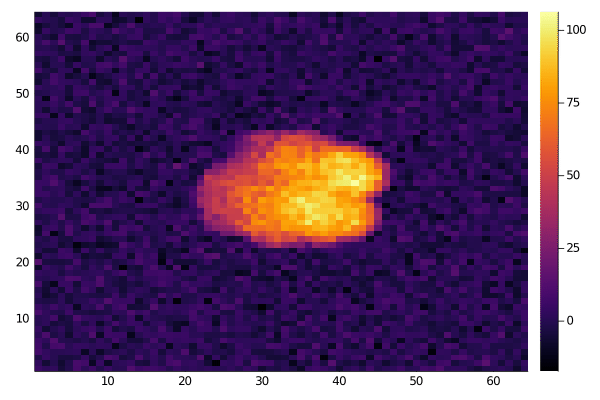

In [5]:
anim = @animate for i in 1:frame_num
    heatmap(frames[i])
end
gif(anim, "afm_output.gif", fps = 10)

In [6]:
@time result = getafmposteriors_alpha(frames[1, :], model_array[1:2, :], q_array[1:2, :], param_array)

func is fft_convolution
model_id = 1
model_id = 2
  2.695689 seconds (10.81 M allocations: 422.920 MiB, 5.40% gc time)


1-element Array{Any,1}:
 Main.MDToolbox.posteriorResult([2, 2], [1, 1], [5.461717005131233e-5; 0.9999453828299488], (64, 2), -9494.651515355828, 2, 2, 1, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [7]:
# @time result = getafmposteriors_alpha(frames, model_array, q_array, param_array)

# MDToolbox.outputResults(result, "afm_rotate_test_seed_$(seed_num)_sigma_$(sigma)_frame_num_$(frame_num).txt");